In [1]:
import json,dataUtils,naiveBayes,logReg
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt      
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

In [2]:
#preprocessing each txt file
dataUtils.preProcessData('aclImdb')
#creating,saving the dictionary
dictionary = dataUtils.createWordDictionary('aclImdb')
with open('data/dict.json', 'w') as f :
    json.dump(dictionary, f) 
#creating files for combinations of m,n
dataUtils.createFiles(dictionary)

 

preprocessing folder: aclImdb/train/pos
preprocessing folder: aclImdb/train/neg
preprocessing folder: aclImdb/test/pos
preprocessing folder: aclImdb/test/neg
All files have been preprocessed

Creating file for m: 100, n: 0
Creating file for m: 500, n: 0


KeyboardInterrupt: 

In [3]:
#tests combinations of m,n after createFiles() has created all the np files
#we get high Accuracy with n=0 and m=2000 , we could also use n=100 
#default hyperparameters : h=0.1 , iterations=1 , reg=0 , thres=0.0001
dataUtils.printAccuracyForEach_m_n()    

/home/chris/Documents/CS/5/ai/hw2/logReg.py:39: RuntimeWarning: divide by zero encountered in log
  return y.dot( np.log(p) ) + (1-y).dot(np.log(1-p))


n:0 m:100 Accuracy: 0.61936
n:0 m:500 Accuracy: 0.79008
n:0 m:1000 Accuracy: 0.8124
n:0 m:2000 Accuracy: 0.83952
n:0 m:4000 Accuracy: 0.8412
n:100 m:100 Accuracy: 0.58336
n:100 m:500 Accuracy: 0.75568
n:100 m:1000 Accuracy: 0.7828
n:100 m:2000 Accuracy: 0.82008


KeyboardInterrupt: 

In [2]:
#we set n=0,m=2000 and split the data
array = np.load("data/0_2000.npy")
trainArray = array[:25000]
valArray =array[25000:] 

np.random.shuffle(trainArray)
X_train = trainArray[:,:trainArray.shape[1]-1]
y_train = trainArray[:,trainArray.shape[1]-1:]

X_val = valArray[:,:valArray.shape[1]-1]
y_val = valArray[:,valArray.shape[1]-1:]

X_cv, X_test, y_cv, y_test= train_test_split(X_val, y_val, train_size=0.5,test_size=0.5, random_state=101)

In [ ]:
#test the hyperparameters h and iter
dataUtils.printAccuracyForEach_h_iter(X_train,y_train,X_cv,y_cv)   #testing hyperparameters(step/h and iterations)

In [ ]:
#test the amount of regularization
#the accuracy drops when we use regularization >0
w = logReg.gradientAscent(X_train,y_train,0.0001,1,0.05,0.01)
logRegPredictions = logReg.predict(w,X_cv)
print("Accuracy:",metrics.accuracy_score(y_cv, logRegPredictions))

w = logReg.gradientAscent(X_train,y_train,0.0001,1,0.05,0.1)
logRegPredictions = logReg.predict(w,X_cv)
print("Accuracy:",metrics.accuracy_score(y_cv, logRegPredictions))

In [3]:
#applying our algorithm after deciding the hyperparameters
#accuracy ~84%
w = logReg.gradientAscent(X_train,y_train,0.0001,1,0.05,0)
logRegPredictions = logReg.predict(w,X_test)

print("Accuracy:",metrics.accuracy_score(y_test, logRegPredictions))
print(classification_report(y_test,logRegPredictions))

/home/chris/Documents/CS/5/ai/Untitled Folder/logReg.py:39: RuntimeWarning: divide by zero encountered in log
  return y.dot( np.log(p) ) + (1-y).dot(np.log(1-p))


Accuracy: 0.84672
              precision    recall  f1-score   support

         0.0       0.87      0.82      0.84      6210
         1.0       0.83      0.87      0.85      6290

    accuracy                           0.85     12500
   macro avg       0.85      0.85      0.85     12500
weighted avg       0.85      0.85      0.85     12500



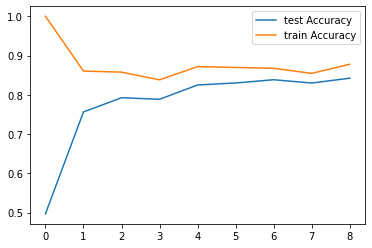

In [4]:
#get the metrics for our algorithm for various learning sizes and print the learning curves
#executed in ~15 secs
logMetrics = logReg.getMetrics(X_train,y_train,X_test,y_test)      

In [ ]:
#we can also plot the F1-Score curves
plt.plot(range(logMetrics[4].shape[0]),logMetrics[3][:,0], label="F1 Score of Negatives" )
plt.plot(range(logMetrics[4].shape[0]),logMetrics[3][:,1] ,label="F1 Score of Positives")   
plt.legend()
plt.show()

In [ ]:
#naive Bayes without feature selection (executed in ~3 mins , accuracy ~83%)
bayesPredictions = naiveBayes.predictBayes(X_train,y_train,X_test)           #takes 2 mins for X with 2000 features
print("Accuracy:",metrics.accuracy_score(y_test, bayesPredictions))
print(classification_report(y_test,bayesPredictions))

In [ ]:
#apply feature selection for faster execution of Naive Bayes 
clf = ExtraTreesClassifier(n_estimators=50)
clf = clf.fit(X_cv, y_cv.ravel())
model = SelectFromModel(clf, prefit=True)
X_trainNB = model.transform(X_train)
X_testNB = model.transform(X_test)
X_cvNB = model.transform(X_cv)

In [ ]:
#after the feature selection , naive bayes is faster but less accurate
#executed in ~40 secs , accuracy drops by 2% (~81%)

bayesPredictions = naiveBayes.predictBayes(X_trainNB,y_train,X_testNB) 
print("Accuracy:",metrics.accuracy_score(y_test, bayesPredictions))
print(classification_report(y_test,bayesPredictions))

In [ ]:
#get the metrics for our algorithm for various learning sizes and print the learning curves
#executed in ~7 mins 
bayesMetrics = naiveBayes.getMetrics(X_trainNB,y_train,X_testNB,y_test)

In [ ]:
#we can also plot the F1-Score curves
plt.plot(range(bayesMetrics[4].shape[0]),bayesMetrics[4][:,0], label="F1 Score of Negatives" )
plt.plot(range(bayesMetrics[4].shape[0]),bayesMetrics[4][:,1] ,label="F1 Score of Positives")   
plt.legend()
plt.show()

In [ ]:
#finally we compare our implementation with the scikit-learn library

#using the data before feature selection
clf = SGDClassifier(loss="log").fit(X_train, y_train.ravel())
p3 = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, p3))
print(classification_report(y_test,p3))
#has ~3% higher accuracy than our implementation

#using the data after feature selection
from sklearn.naive_bayes import BernoulliNB
clf = BernoulliNB(alpha=1.0)
clf.fit(X_trainNB,y_train.ravel())
pd = clf.predict(X_testNB)
print("Accuracy:",metrics.accuracy_score(y_test, pd))
print(classification_report(y_test,pd))
#has the same accuracy as our implementation
